# Problem Sheet 4

## Pre-Amble

In [1]:
import numpy as np
from iminuit import Minuit, cost
from scipy.stats import norm
import matplotlib.pyplot as plt
from iminuit import Minuit, cost

## Question 1.

In [2]:
g = np.random.default_rng(seed=1)
N = 10000
x = g.normal(0.0, 1.0, N) # Standard deviation 0.25

In [3]:
print("Biased estimate of the variance:", np.var(x))

Biased estimate of the variance: 0.9969943211866304


In [4]:
jackknife_samples = np.zeros((N, N-1))
for i in range(N):
    jackknife_samples[i, :] = np.concatenate([x[:i], x[i+1:]])

In [5]:
jackknife_estimates = np.var(jackknife_samples, axis=1)
jackknife_bias_estimate = (N - 1)*(np.mean(jackknife_estimates) - np.var(x))

In [6]:
jackknife_bias_estimate

-9.970940415227059e-05

In [7]:
np.var(x)

0.9969943211866304

In [8]:
np.var(x) - jackknife_bias_estimate

0.9970940305907827

In [9]:
np.var(x, ddof=1)

0.9970940305896894

## Question 3.

We use throw toys to ascertain the distribution of the T-statistic under the two hypotheses. Namely, we have use $Y$ to represent the underlying distribution of $\cos(\theta)$, $Z$ to be a measurement error random variable, and then $X = Y + Z$ to represent the observed value of $\cos(\theta)$. $Z$ is distributed as $N(0, 0.05^2)$, while $Y$ has a distribution depending on the hypothesis. Under $H_0$ it has distribution whose cdf is
$$1 - \frac{\arccos(x)}{\pi}, x \in (-1,1)$$
For $x$ values less than $-1$,  it is zero, and one for $x>1$. Under $H_1$,
$$Y \approx (1-\hat{f})d + \hat{f}N(-1,0.05)$$
where $\hat{f}$ is the best MLE fit for the data.

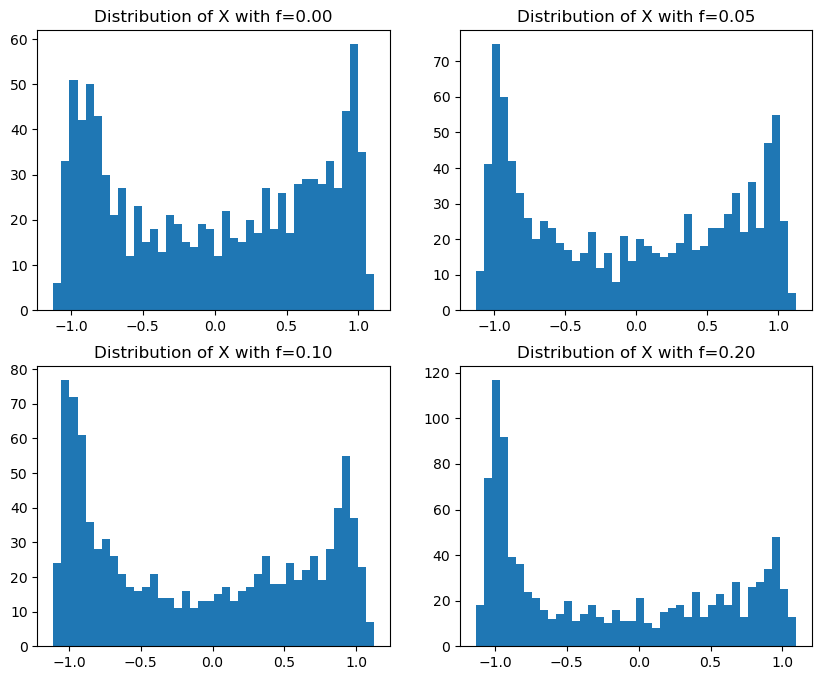

In [10]:
def toys_X_f(f, N, s=1):
    num_2_decays = round(f*N)
    num_3_decays = N - num_2_decays
    g = np.random.default_rng(seed=s)
    ang_3_decays = g.uniform(0, np.pi, num_3_decays)
    ang_sample = np.concatenate([np.pi*np.ones(num_2_decays), ang_3_decays])
    X_sample = np.cos(ang_sample)
    X_sample += g.normal(0, 0.05, N)
    return X_sample

fig, ax = plt.subplots(2, 2, figsize=(10,8))
ax[0, 0].hist(toys_X_f(0.00, 1000), bins=40)
ax[0, 1].hist(toys_X_f(0.05, 1000), bins=40)
ax[1, 0].hist(toys_X_f(0.10, 1000), bins=40)
ax[1, 1].hist(toys_X_f(0.20, 1000), bins=40)
ax[0, 0].set_title("Distribution of X with f=0.00")
ax[0, 1].set_title("Distribution of X with f=0.05")
ax[1, 0].set_title("Distribution of X with f=0.10")
ax[1, 1].set_title("Distribution of X with f=0.20")
plt.show()

In [11]:
# Use histogram to approximate the pdf of D

xrange = (-1.5, 1.5)
nh, xe = np.histogram(toys_X_f(0.00, 10000000) , bins=1000, range=xrange, density=True )

# and get the cumalative sums
bw = xe[1]-xe[0]
Fh = np.cumsum(nh)*bw

# the pdf (note use of np.digitize)
def d_pdf(x):
    bin_inds = np.digitize(x, xe)-1
    bin_inds[ bin_inds >= len(nh) ] = len(nh)-1
    bin_inds[ bin_inds < 0 ] = 0
    return nh[bin_inds]

In [42]:
def model_pdf(x, f):
    return ((1-f)*d_pdf(x)) + (f*norm.pdf(x, -1, 0.05))

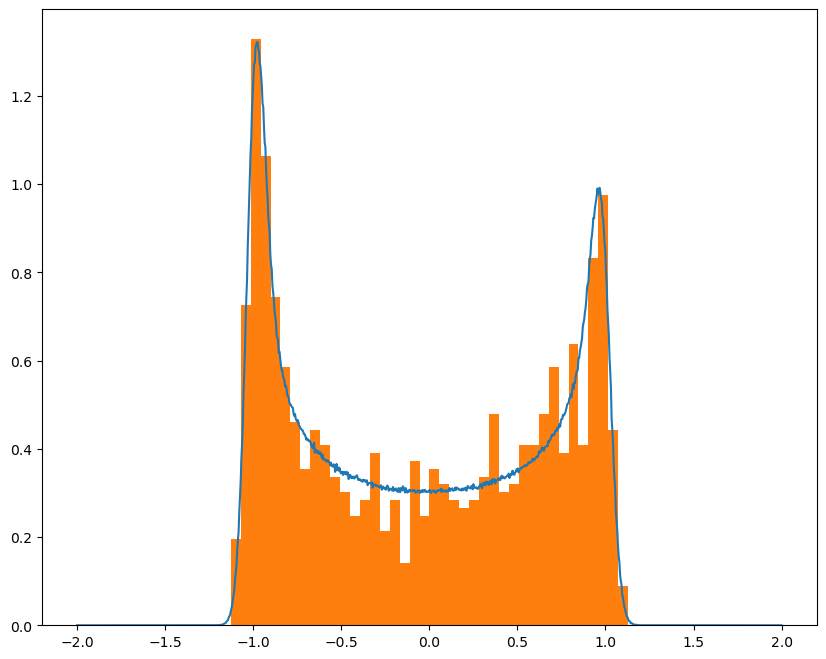

In [50]:
fig = plt.figure(figsize=(10,8))
ax = plt.axes()
x_plot = np.linspace(-2, 2, 1000)
ax.plot(x_plot, model_pdf(x_plot, 0.05))
ax.hist(toys_X_f(0.05, 1000), bins=40, density=True)
plt.show()

In [63]:
np.log(8)

2.0794415416798357

In [91]:
def T_estimator(x, f_hat):
    L_0 = np.prod(model_pdf(x, 0))
    L_1 = np.prod(model_pdf(x, f_hat))
    T = -2*np.log(L_1) + 2*np.log(L_0)
    return T

In [57]:
X_sample = toys_X_f(0.05, 10000)
nll = cost.UnbinnedNLL(X_sample, model_pdf )
mi  = Minuit(nll, f=0)
mi.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.373e+04                  │              Nfcn = 24               │
│ EDM = 4.65e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ f    │   0.055   │   0.004   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        f │
├───┼──────────┤
│ f │ 1.78e-05 │
└───┴──────────┘

### Question 3.c.

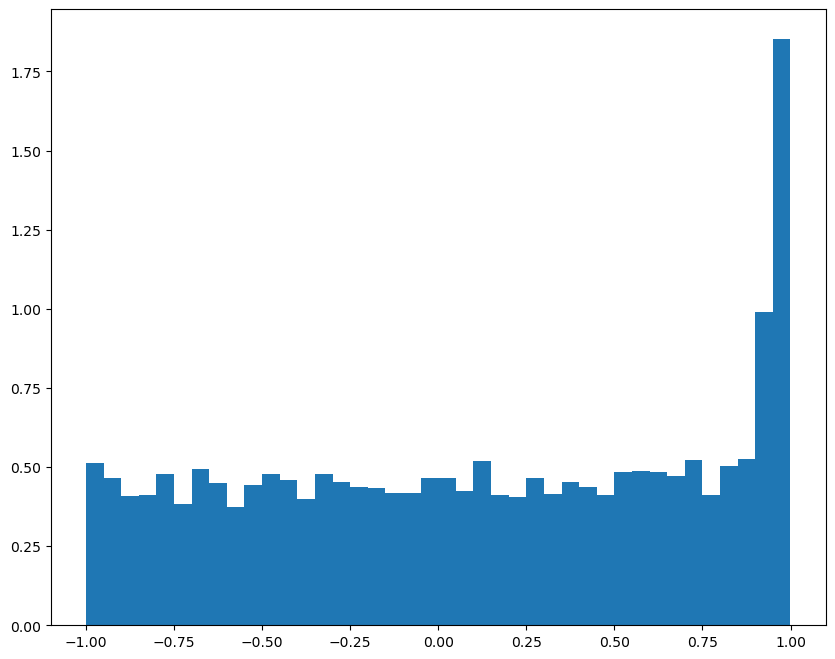

In [12]:
kaon_sample = np.load("kaon.npy")
fig = plt.figure(figsize=(10,8))
ax = plt.axes()
ax.hist(kaon_sample, bins=40, density=True)
plt.show()

In [15]:
np.min(kaon_sample)

-0.9999528723777567

In [97]:
nll = cost.UnbinnedNLL(kaon_sample, model_pdf )
mi  = Minuit(nll, f=0)
mi.migrad()

/home/jhughes2712/miniconda3/envs/mphildis_pds/lib/python3.9/site-packages/iminuit/cost.py:75: RuntimeWarning: invalid value encountered in log
  return np.log(x + 1e-323)


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 7931                       │              Nfcn = 88               │
│ EDM = 1.41e+03 (Goal: 0.0002)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ f    │   0.00    │   0.01    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        f │
├───┼──────────┤
│ f │ 9.53e-05 │
└───┴──────────┘

## Question 4

In [122]:
peaking = np.load("peaking.npy")
peaking = peaking[np.abs(peaking) < 30]
len(peaking)

9904

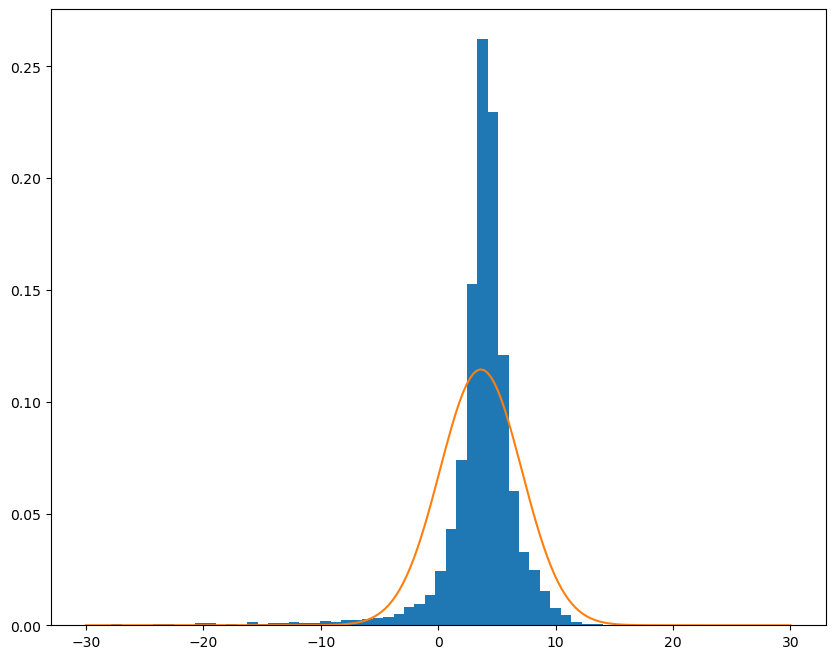

In [124]:
fig = plt.figure(figsize=(10,8))
x_plot = np.linspace(-30,30,201)
ax = plt.axes()
ax.hist(peaking, bins=50, density=True)
ax.plot(x_plot, norm.pdf(x_plot, loc=np.mean(peaking), scale=np.std(peaking, ddof=1)))
plt.show()

In [133]:
def double_gaussian(x, mu1, mu2, sg1, sg2):
    return 0.5*(norm.pdf(x, mu1, sg1) + norm.pdf(x, mu2, sg2))

nll = cost.UnbinnedNLL(peaking, double_gaussian )
mi  = Minuit(nll, mu1=1, mu2=1, sg1=1, sg2=1)
mi.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4.69e+04                   │              Nfcn = 316              │
│ EDM = 3.91e-06 (Goal: 0.0002)    │            time = 0.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu1  │   4.091   │   0.018   │            │            │         │         │       │
│ 1 │ mu2  │   3.00    │   0.08    │            │            │         │         │       │
│ 2 │ sg1  │   1.013   │   0.015   │            │            │         │         │       │
│ 3 │ sg2  │   5.18    │   0.06    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────────────────────────┐
│     │       mu1       mu2       sg1       sg2 │
├─────┼─────────────────────────────────────────┤
│ mu1 │  0.000328 -0.000205  3.89e-06 -4.81e-05 │
│ mu2 │ -0.000205   0.00687 -8.32e-05 -0.000214 │
│ sg1 │  3.89e-06 -8.32e-05  0.000238  0.000129 │
│ sg2 │ -4.81e-05 -0.000214  0.000129   0.00383 │
└─────┴─────────────────────────────────────────┘

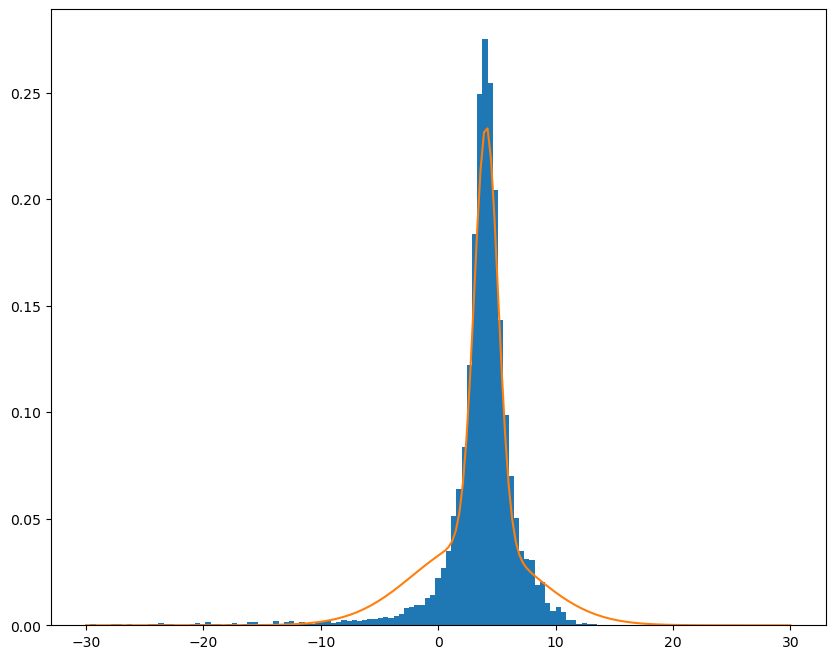

In [134]:
fig = plt.figure(figsize=(10,8))
x_plot = np.linspace(-30,30,201)
ax = plt.axes()
ax.hist(peaking, bins=100, density=True)
ax.plot(x_plot, double_gaussian(x_plot, *mi.values))
plt.show()

In [135]:
def triple_gaussian(x, mu1, mu2, mu3, sg1, sg2, sg3):
    return (norm.pdf(x, mu1, sg1) + norm.pdf(x, mu2, sg2) + norm.pdf(x, mu3, sg3))/3

nll = cost.UnbinnedNLL(peaking, triple_gaussian )
mi  = Minuit(nll, mu1=1, mu2=1, mu3=-10, sg1=1, sg2=1, sg3=10)
mi.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4.591e+04                  │              Nfcn = 342              │
│ EDM = 2.93e-05 (Goal: 0.0002)    │            time = 0.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu1  │   4.013   │   0.029   │            │            │         │         │       │
│ 1 │ mu2  │   4.27    │   0.05    │            │            │         │         │       │
│ 2 │ mu3  │   2.27    │   0.13    │            │            │         │         │       │
│ 3 │ sg1  │   0.844   │   0.021   │            │            │         │         │       │
│ 4 │ sg2  │   1.71    │   0.04    │            │            │         │         │       │
│ 5 │ sg3  │   6.10    │   0.09    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────────────────────────────────────────────┐
│     │       mu1       mu2       mu3       sg1       sg2       sg3 │
├─────┼─────────────────────────────────────────────────────────────┤
│ mu1 │  0.000844 -0.000893  0.000323 -3.77e-05  0.000159  0.000105 │
│ mu2 │ -0.000893   0.00296  -0.00171  5.48e-06  -3.8e-05 -0.000507 │
│ mu3 │  0.000323  -0.00171    0.0166  3.06e-05 -0.000618 -0.000496 │
│ sg1 │ -3.77e-05  5.48e-06  3.06e-05  0.000459 -0.000236  9.46e-05 │
│ sg2 │  0.000159  -3.8e-05 -0.000618 -0.000236    0.0014  0.000323 │
│ sg3 │  0.000105 -0.000507 -0.000496  9.46e-05  0.000323    0.0084 │
└─────┴─────────────────────────────────────────────────────────────┘

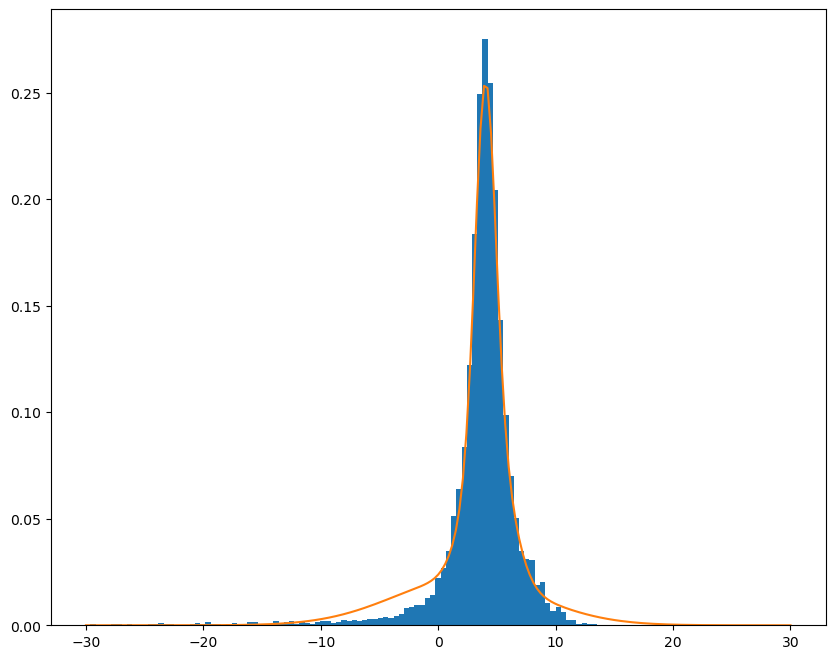

In [136]:
fig = plt.figure(figsize=(10,8))
x_plot = np.linspace(-30,30,201)
ax = plt.axes()
ax.hist(peaking, bins=100, density=True)
ax.plot(x_plot, triple_gaussian(x_plot, *mi.values))
plt.show()

In [129]:
def kde(x, data, h=0.1):
    res = np.zeros_like(x)
    for dpoint in data:
        res = res + norm.pdf(x, dpoint, h) / len(data)    
    return res

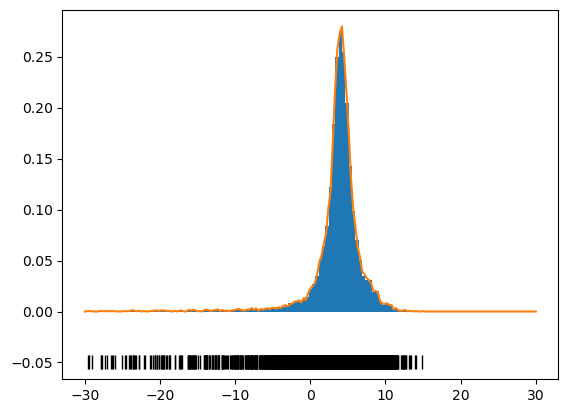

In [138]:
fig, ax = plt.subplots()

ax.hist(peaking, bins=100, density=True)

ax.plot(peaking, np.full_like(peaking,-0.05), "k|", ms=10, lw=2)

ax.plot(x_plot, kde(x_plot, peaking))

plt.show()